C:\Users\Armin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


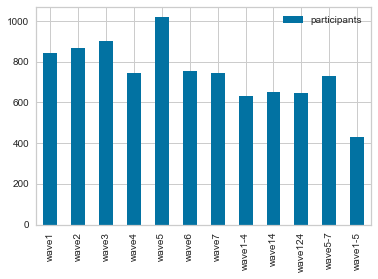

In [1]:
#Steps 5-7

import numpy as np
import pandas as pd
import pandas_profiling as pp
from IPython.display import display, HTML
import pymannkendall as mk
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from yellowbrick.regressor import ResidualsPlot
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics, preprocessing
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import KFold, cross_val_score, RepeatedKFold
from itertools import combinations
import itertools
from statsmodels.stats.outliers_influence import variance_inflation_factor
import ipynb.fs.full.script
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statistics import *



%matplotlib inline
pd.options.display.max_columns = None

pd.options.display.max_rows = 10
pd.options.display.width = 200
np.set_printoptions(precision = 4, suppress = True) 

legit_classes1 = [67,71,72,74,77,78,79,81,83,86,100,101,103,121,122,125,126,127,129,130,131,133,135,138]
legit_classes2 = [73,74,78,81,82,86,100,103,124,125,131,133,135,141,250,251,256,258,259,261,262,263,272,273,277,279,290,291,292,296,297,298,299,300,301,302,303,304,305,306,307,308,310]
participants = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/8. Metadata/Participant_Info.csv", sep= ';')

par_w1 = participants["W1"] == 1
par_w2 = participants["W2"] == 1
par_w3 = participants["W3"] == 1
par_w4 = participants["W4"] == 1
par_w5 = participants["W5"] == 1
par_w6 = participants["W6"] == 1
par_w7 = participants["W7"] == 1

total1 = len(participants[par_w1])
total2 = len(participants[par_w3])
total3 = len(participants[par_w2])
total4 = len(participants[par_w4])
total5 = len(participants[par_w5])
total6 = len(participants[par_w6])
total7 = len(participants[par_w7])
total1_4 = len(participants[par_w1 & par_w2 & par_w3 & par_w4])
total14 = len(participants[par_w1 & par_w4])
total124 = len(participants[par_w1 & par_w2 & par_w4])
total5_7 = len(participants[par_w5 & par_w6 & par_w7])
total1_5 = len(participants[par_w1 & par_w2 & par_w3 & par_w4 & par_w5])

par_per_wave = pd.DataFrame({
    'participants': [total1, total2, total3, total4, total5, total6, total7, total1_4, total14, total124, total5_7, total1_5]}, index=['wave1', 'wave2', 'wave3', 'wave4', 'wave5', 'wave6', 'wave7', 'wave1-4', 'wave14','wave124', 'wave5-7', 'wave1-5'])

par_per_wave.plot.bar()


#display(participants[par_w1 & par_w2 & par_w3 & par_w4 & par_w5 & par_w6 & par_w7])
#print(participants[par_w1 & par_w2 & par_w3 & par_w4].count)

In [2]:
#getting participants from 5 to 7
participants5_7 = participants[['Child','Class_Y3']][par_w5 & par_w6 & par_w7]
participants5_7 = participants5_7[participants5_7["Class_Y3"].isin(legit_classes2)]
par_57 = participants5_7
participants5_7 = participants5_7["Child"].tolist()
schools = participants['School'][participants['Child'].isin(participants5_7)].unique().tolist()
display(schools)

[26, 29, 28, 30, 32, 33, 34, 38, 39, 40, 43, 54, 55, 42, 56, 57, 58, 59, 60]

In [3]:
#fit
#compare waves with eachother as percentage for example
fit_clean = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/5. Fitbit data/Fitbit_W17_cleaned_imputation.csv", sep= ';')
fit_clean5_7 = fit_clean[fit_clean["Child"].isin(participants5_7)]

fit_clean5_7 = fit_clean5_7[fit_clean5_7["Wave"] <= 3]

fit_clean5_7 = fit_clean5_7.drop(columns = ['Imputed','Participated'])
fit_clean5_7 = fit_clean5_7.sort_values(['Child','Wave', 'Day'])
display(fit_clean5_7[fit_clean5_7['Child'] == 1222])

,School,Class,Child,Sex,Age,Wave,Day,Date,Steps,Minutes_MVPA


In [4]:
# get the average amount of steps per child over wave 5-7
avg_Steps_57 = fit_clean5_7[['School', 'Class', 'Child', 'Wave','Day','Steps']].copy()
avg_Steps_57 = avg_Steps_57.groupby('Child').mean()
avg_Steps_57 = avg_Steps_57.drop(columns = ['Wave', 'Day', 'Class', 'School'])
avg_Steps_57.reset_index()

full_table_57 = avg_Steps_57
full_table_57 = full_table_57.reset_index()
temp = fit_clean5_7.drop(columns = ['Minutes_MVPA', 'Date', 'Steps', 'Day', 'Wave'])
temp = temp.drop_duplicates(subset = ["Child"])

full_table_57 = full_table_57.merge(temp)
full_table_57

,Child,Steps,School,Class,Sex,Age
0,1414,8578.900000,26,74,0,9.0
1,1420,14617.727273,26,74,0,10.0
2,1421,10334.071429,26,74,1,10.0
3,1422,7011.444444,26,74,0,9.0
4,1423,6403.100000,26,74,0,11.0
...,...,...,...,...,...,...
209,4889,15484.777778,40,131,1,9.0
210,4890,12228.888889,40,131,1,9.0
211,6135,NaN,40,131,1,9.0
212,6137,NaN,40,131,1,9.0


In [5]:
#socio
socio_gbl_567 = pd.read_excel("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/1. Social network data/social_networks_global_waves567.xlsx", sep= ';')
socio_gbl_567 = pd.read_excel("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/1. Social network data/social_networks_global_waves567.xlsx", sep= ';')
socio_lcl_567 = pd.read_excel("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/1. Social network data/social_networks_local_waves567.xlsx", sep= ';')
socio_lcl_567 = pd.read_excel("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/1. Social network data/social_networks_local_waves567.xlsx", sep= ';')

socio_lcl_567 = socio_lcl_567.rename(columns={"Node": "Child"})
socio_lcl_567 = socio_lcl_567.drop(['Unnamed: 0', 'ClusteringC'], axis = 1)
socio_gbl_567 = socio_gbl_567.drop(['Unnamed: 0'], axis = 1)

#Add socio data to the full table of week 5-7
full_table_57 = full_table_57.merge(socio_lcl_567, how = 'left')
full_table_57 = full_table_57.merge(socio_gbl_567, how = 'left')
display(full_table_57)
children = full_table_57['Child']

,Child,Steps,School,Class,Sex,Age,Betweeness,Closeness,Degree,Eigenvector,Avg_Short_Path,Density,Edges,Nodes
0,1414,8578.900000,26,74,0,9.0,0.001515,0.592593,1.000000,0.277652,0.814103,0.570513,89.0,13.0
1,1420,14617.727273,26,74,0,10.0,0.024387,0.592593,1.583333,0.277652,0.814103,0.570513,89.0,13.0
2,1421,10334.071429,26,74,1,10.0,0.005195,0.592593,1.083333,0.277652,0.814103,0.570513,89.0,13.0
3,1422,7011.444444,26,74,0,9.0,0.024387,0.592593,1.583333,0.277652,0.814103,0.570513,89.0,13.0
4,1423,6403.100000,26,74,0,11.0,0.013763,0.533333,1.333333,0.245043,0.814103,0.570513,89.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,4889,15484.777778,40,131,1,9.0,0.016560,0.689655,0.900000,0.291802,1.702381,0.438095,184.0,21.0
210,4890,12228.888889,40,131,1,9.0,0.010701,0.666667,0.800000,0.253143,1.702381,0.438095,184.0,21.0
211,6135,NaN,40,131,1,9.0,0.029877,0.666667,1.000000,0.282171,1.702381,0.438095,184.0,21.0
212,6137,NaN,40,131,1,9.0,0.054766,0.606061,1.050000,0.211072,1.702381,0.438095,184.0,21.0


In [6]:
#questionnaire 
questionnaire_5 = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/4. Questionnaire data/W1_Main_questions.csv", sep= ';')
questionnaire_6 = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/4. Questionnaire data/W2_Main_questions.csv", sep= ';')
questionnaire_7 = pd.read_csv("C:/Users/Armin/Documents/VU/thesis/original/02_MyMovez/4. Questionnaire data/W3_Main_questions.csv", sep= ';')
questionnaire_567 = questionnaire_5.merge(questionnaire_6, on = 'Child')
questionnaire_567 = questionnaire_567.merge(questionnaire_7, on = 'Child')
#display(questionnaire_123.filter(regex=("ME_Internet_Game_Exposure_ME_SM.*")))

questionnaire_567 = questionnaire_567[['Child', 'ME_Internet_Game_Exposure_ME_Int_days_x', 'PA_motivation_PA_motiv_.intrin2_x','PA_motivation_PA_motiv_.extrin1_x', 
                                       'PA_motivation_PA_motiv_.extrin3_x', 'PA_motivation_PA_motiv_.intrin3_x', 'ME_Internet_Game_Exposure_ME_Int_hours_x', 'PA_Barriers_Resource_place_1']]
temp = questionnaire_6.loc[:, questionnaire_6.columns.str.contains('facili')]
temp['Child'] = ""
temp = questionnaire_6[temp.columns]
temp = temp.set_index('Child')

# Give a 0 or 1 value for each facility wether it is or is not in the enviroment of the child
for index, row in temp.iterrows():
    temp.loc[index,'Bos'] = row.str.contains('Bos').any()
    temp.loc[index,'Park'] = row.str.contains('Park').any()
    temp.loc[index,'Speelplein'] = row.str.contains('Speelplein').any()
    temp.loc[index,'Speeltuin'] = row.str.contains('Speeltuin').any()
    temp.loc[index,'Sportschool'] = row.str.contains('Sportschool').any()
    temp.loc[index,'Sportclub'] = row.str.contains('Sportclub').any()
    temp.loc[index,'Zwembad'] = row.str.contains('Zwembad').any()
    temp.loc[index,'Meer_zee'] = row.str.contains('Meer_zee').any()
    temp.loc[index,'Dansschool'] = row.str.contains('Dansschool').any()
    temp.loc[index,'Sporthal'] = row.str.contains('Sporthal').any()
    temp.loc[index,'Grasveld'] = row.str.contains('Grasveld').any()
    
temp.drop(temp.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]],axis=1,inplace=True)
temp = temp.astype(int)
questionnaire_567 = questionnaire_567[['Child', 'ME_Internet_Game_Exposure_ME_Int_days_x','PA_motivation_PA_motiv_.intrin2_x', 
                                       'PA_motivation_PA_motiv_.extrin1_x', 'PA_motivation_PA_motiv_.extrin3_x', 'PA_motivation_PA_motiv_.intrin3_x', 
                                       'ME_Internet_Game_Exposure_ME_Int_hours_x', 'PA_Barriers_Resource_place_1']].dropna()
questionnaire_567 = questionnaire_567.loc[questionnaire_567['Child'].isin(children)]
questionnaire_567.drop_duplicates()


C:\Users\Armin\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Child,ME_Internet_Game_Exposure_ME_Int_days_x,PA_motivation_PA_motiv_.intrin2_x,PA_motivation_PA_motiv_.extrin1_x,PA_motivation_PA_motiv_.extrin3_x,PA_motivation_PA_motiv_.intrin3_x,ME_Internet_Game_Exposure_ME_Int_hours_x,PA_Barriers_Resource_place_1
0,1814,1.0,5.0,4.0,1.0,6.0,2.0,1.0
1,1815,7.0,6.0,1.0,1.0,6.0,4.0,2.0
2,1819,1.0,6.0,4.0,1.0,6.0,3.0,6.0
6,1428,4.0,6.0,1.0,1.0,5.0,3.0,1.0
13,1606,5.0,6.0,1.0,1.0,6.0,3.0,1.0
...,...,...,...,...,...,...,...,...
313,1429,7.0,6.0,1.0,1.0,6.0,3.0,6.0
359,1817,7.0,6.0,6.0,6.0,6.0,3.0,1.0
390,2902,5.0,3.0,3.0,5.0,4.0,5.0,5.0
414,3183,7.0,6.0,1.0,1.0,4.0,5.0,1.0


In [7]:
temp = temp.reset_index()
full_table_57 = full_table_57.merge(temp)

# merge with the barrier question
temp = questionnaire_567
full_table_57 = full_table_57.merge(temp)
display(full_table_57)
full_table_57 = full_table_57.dropna()

full_table_57['PA_Barriers_Resource_place_1'] = full_table_57['PA_Barriers_Resource_place_1'].fillna(method = 'ffill')

,Child,Steps,School,Class,Sex,Age,Betweeness,Closeness,Degree,Eigenvector,Avg_Short_Path,Density,Edges,Nodes,Bos,Park,Speelplein,Speeltuin,Sportschool,Sportclub,Zwembad,Meer_zee,Dansschool,Sporthal,Grasveld,ME_Internet_Game_Exposure_ME_Int_days_x,PA_motivation_PA_motiv_.intrin2_x,PA_motivation_PA_motiv_.extrin1_x,PA_motivation_PA_motiv_.extrin3_x,PA_motivation_PA_motiv_.intrin3_x,ME_Internet_Game_Exposure_ME_Int_hours_x,PA_Barriers_Resource_place_1
0,1428,7960.333333,26,74,1,9.0,0.035877,0.533333,1.500000,0.239914,0.814103,0.570513,89.0,13.0,0,1,0,1,0,0,0,1,1,0,1,4.0,6.0,1.0,1.0,5.0,3.0,1.0
1,1429,13182.846154,26,74,1,11.0,0.000000,0.750000,0.750000,0.365000,0.814103,0.570513,89.0,13.0,0,0,1,1,1,1,1,1,1,1,1,7.0,6.0,1.0,1.0,6.0,3.0,6.0
2,1605,5356.000000,29,81,1,12.0,0.035351,0.729730,1.629630,0.187245,1.361111,0.638889,483.0,28.0,0,0,0,1,0,0,1,0,0,0,0,4.0,6.0,2.0,6.0,6.0,3.0,1.0
3,1606,7386.454545,29,81,1,9.0,0.017900,0.870968,1.518519,0.240861,1.361111,0.638889,483.0,28.0,0,1,1,1,1,1,1,0,1,1,1,5.0,6.0,1.0,1.0,6.0,3.0,1.0
4,1608,10115.538462,29,81,1,10.0,0.040500,0.818182,1.777778,0.219043,1.361111,0.638889,483.0,28.0,1,0,1,1,1,1,1,0,1,1,1,2.0,6.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,3202,13575.428571,43,141,1,10.0,0.023271,0.601604,1.235294,0.203127,1.212418,0.565359,173.0,18.0,0,0,1,1,0,0,0,0,0,0,1,4.0,5.0,1.0,2.0,5.0,3.0,2.0
148,3203,13161.214286,43,141,1,10.0,0.041356,0.661765,1.529412,0.233438,1.212418,0.565359,173.0,18.0,0,0,1,1,1,1,0,0,1,1,1,7.0,6.0,1.0,1.0,6.0,4.0,1.0
149,3205,7536.166667,43,141,0,9.0,0.009506,0.630252,0.941176,0.222933,1.212418,0.565359,173.0,18.0,0,1,0,1,0,0,1,0,0,0,0,7.0,6.0,1.0,1.0,6.0,4.0,2.0
150,3215,10056.615385,43,141,1,9.0,0.030782,0.696594,1.411765,0.254826,1.212418,0.565359,173.0,18.0,0,0,0,1,0,0,0,0,0,1,1,7.0,6.0,5.0,1.0,6.0,6.0,1.0


In [8]:
copy = full_table_57.drop(columns = ['Child', 'School', 'Class', 'Sex', 'Age', 'Nodes', 'Edges'])

In [9]:
copy.describe()

,Steps,Betweeness,Closeness,Degree,Eigenvector,Avg_Short_Path,Density,Bos,Park,Speelplein,Speeltuin,Sportschool,Sportclub,Zwembad,Meer_zee,Dansschool,Sporthal,Grasveld,ME_Internet_Game_Exposure_ME_Int_days_x,PA_motivation_PA_motiv_.intrin2_x,PA_motivation_PA_motiv_.extrin1_x,PA_motivation_PA_motiv_.extrin3_x,PA_motivation_PA_motiv_.intrin3_x,ME_Internet_Game_Exposure_ME_Int_hours_x,PA_Barriers_Resource_place_1
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,10699.759796,0.022452,0.697387,1.268977,0.213008,1.301821,0.602463,0.243243,0.418919,0.628378,0.831081,0.310811,0.459459,0.351351,0.175676,0.250000,0.364865,0.797297,4.993243,5.236486,1.472973,1.520270,5.601351,3.486486,1.837838
std,3134.480814,0.027559,0.109882,0.349426,0.057007,0.188601,0.110919,0.430498,0.495057,0.484879,0.375953,0.464397,0.500046,0.479014,0.381836,0.434483,0.483027,0.403378,2.208507,1.263628,1.290710,1.220402,0.994816,1.643319,1.493997
min,4724.900000,0.000000,0.377358,0.500000,0.044807,0.814103,0.415789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,8186.634615,0.005738,0.634836,1.000000,0.179696,1.212418,0.492611,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,5.000000,1.000000,1.000000,6.000000,2.000000,1.000000
50%,10335.227273,0.013595,0.704167,1.235294,0.224316,1.271053,0.636029,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,6.000000,1.000000,1.000000,6.000000,3.000000,1.000000
75%,13153.380495,0.027708,0.764286,1.562500,0.246146,1.363971,0.691176,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.250000,1.000000,1.000000,7.000000,6.000000,1.000000,1.000000,6.000000,4.000000,2.000000
max,19267.846154,0.151599,0.947368,1.944444,0.365000,1.702381,0.780702,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,6.000000,6.000000,6.000000,6.000000,9.000000,6.000000


In [10]:
#check if 0 is male or female
temp = copy[['Steps']]

temp.loc[(temp['Steps'] < 10000), 'Steps_class'] = 0
temp.loc[(temp['Steps'] > 11700), 'Steps_class'] = 2
temp.loc[(temp['Steps'] > 10000) & (temp['Steps'] < 11700), 'Steps_class'] = 1

copy['Steps_class'] = temp['Steps_class']
temp['Steps_class'].value_counts()

C:\Users\Armin\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Armin\anaconda3\lib\site-packages\pandas\core\indexing.py:850: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(new_indexer, value)
C:\Users\Armin\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

0.0    68
2.0    57
1.0    23
Name: Steps_class, dtype: int64

[0.5789 0.     0.7273]
[0.8462 0.     0.6667]


C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.6875, 0.    , 0.6957])

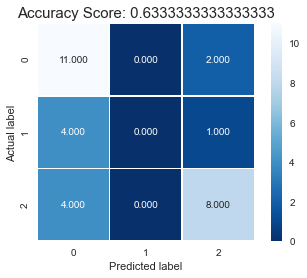

In [11]:
features = copy.drop(columns = ['Steps','Steps_class'])
label = copy['Steps_class']

features_train, features_test, label_train, label_test = train_test_split(features, label, test_size=0.2)

rfc = RandomForestClassifier()
rfc.fit(features_train, label_train)
predictions = rfc.predict(features_test)
score = rfc.score(features_test, label_test)
prec_score = precision_score(label_test, predictions, average = None)
rec_score = recall_score(label_test, predictions, average = None)
f1 = f1_score(label_test, predictions, average = None)

s=confusion_matrix(label_test, predictions)
sns.heatmap(s, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
print(prec_score)
print(rec_score)
f1

In [12]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(features, label)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.0min finished


{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 80}

array([0., 0., 0., 0., 2., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.,
       2., 0., 0., 0., 0., 2., 0., 0., 2., 2., 0., 2., 2.])

[0.4762 0.     0.5556]
[0.8333 0.     0.3571]


C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.6061, 0.    , 0.4348])

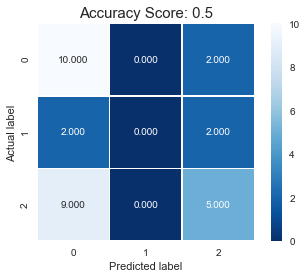

In [13]:
best_random = rf_random.best_estimator_

features = copy.drop(columns = ['Steps','Steps_class'])
label = copy['Steps_class']

features_train, features_test, label_train, label_test = train_test_split(features, label, test_size=0.2)

best_random.fit(features_train, label_train)
predictions = best_random.predict(features_test)
display(predictions)
score = best_random.score(features_test, label_test)
prec_score = precision_score(label_test, predictions, average = None)
rec_score = recall_score(label_test, predictions, average = None)
f1 = f1_score(label_test, predictions, average = None)

s=confusion_matrix(label_test, predictions)
sns.heatmap(s, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)
print(prec_score)
print(rec_score)
f1

In [14]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = model.score(test_features, test_labels)
    prec_score = precision_score(test_labels, predictions, average = 'weighted')
    rec_score = recall_score(test_labels, predictions, average = 'weighted')
    f1 = f1_score(test_labels, predictions, average = 'weighted')
    temp = pd.DataFrame(np.array([[accuracy, prec_score, rec_score, f1]]),
                   columns=['accuracy', 'prec_score', 'rec_score', 'f1'])
    return temp

In [15]:
best_random = rf_random.best_estimator_
rand_for = pd.DataFrame(columns = ['accuracy', 'prec_score', 'rec_score', 'f1'])

for number in range(50):
    features_train, features_test, label_train, label_test = train_test_split(features, label, test_size=0.2)
    rfc.fit(features_train, label_train)
    rand_for = rand_for.append(evaluate(rfc, features_test, label_test), ignore_index=True)
    
op_rand_for = pd.DataFrame(columns = ['accuracy', 'prec_score', 'rec_score', 'f1'])

for number in range(50):
    features_train, features_test, label_train, label_test = train_test_split(features, label, test_size=0.2)
    best_random.fit(features_train, label_train)
    op_rand_for = op_rand_for.append(evaluate(best_random, features_test, label_test), ignore_index=True)

C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedM

C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedM

C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Armin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedM

In [16]:
pd.options.display.max_rows = None

display(rand_for.describe())
display(op_rand_for.describe())

feature_importances = pd.DataFrame(best_random.feature_importances_, index = features_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,accuracy,prec_score,rec_score,f1
count,50.000000,50.000000,50.000000,50.000000
mean,0.528667,0.505152,0.528667,0.494389
std,0.074994,0.104727,0.074994,0.078536
min,0.366667,0.301852,0.366667,0.329032
25%,0.475000,0.428906,0.475000,0.448667
50%,0.500000,0.506742,0.500000,0.480336
75%,0.600000,0.577883,0.600000,0.545813
max,0.700000,0.720598,0.700000,0.703315


,accuracy,prec_score,rec_score,f1
count,50.000000,50.000000,50.000000,50.000000
mean,0.494667,0.430815,0.494667,0.443471
std,0.079500,0.088736,0.079500,0.080371
min,0.333333,0.278675,0.333333,0.310053
25%,0.433333,0.366547,0.433333,0.389252
50%,0.466667,0.424583,0.466667,0.429923
75%,0.566667,0.494381,0.566667,0.503931
max,0.733333,0.659968,0.733333,0.694709


,importance
Density,0.122653
Eigenvector,0.107705
Betweeness,0.105346
Degree,0.104165
Avg_Short_Path,0.103783
Closeness,0.082147
ME_Internet_Game_Exposure_ME_Int_days_x,0.054473
ME_Internet_Game_Exposure_ME_Int_hours_x,0.050628
Sportclub,0.045842
PA_Barriers_Resource_place_1,0.032364


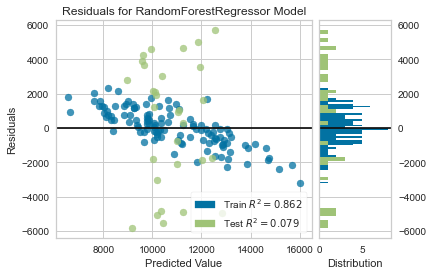

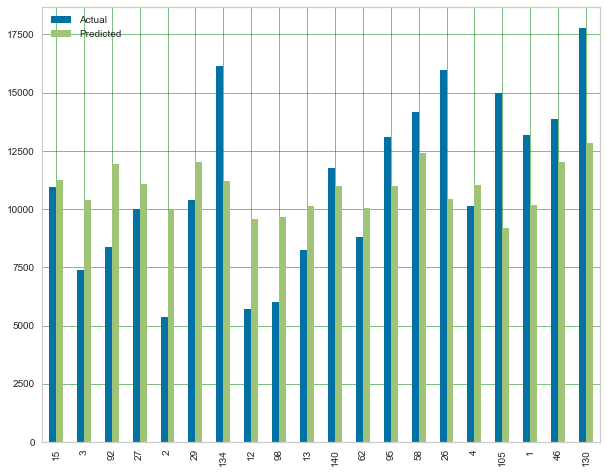

Mean Absolute Error: 3162.1 degrees.
Accuracy: 64.58 %.


In [17]:
# random forest regressor
pd.options.display.max_rows = 10
features = copy.drop(columns = ['Steps','Steps_class'])
label_steps = full_table_57['Steps']

rf = RandomForestRegressor()
features_train, features_test, label_train, label_test = train_test_split(features, label_steps, test_size=0.2)

visualizer = ResidualsPlot(rf)
visualizer.fit(features_train, label_train)  # Fit the training data to the visualizer
visualizer.score(features_test, label_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

predictions = visualizer.predict(features_test)
df = pd.DataFrame({'Actual': label_test, 'Predicted': predictions})
df1 = df.head(20)

df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

errors = abs(predictions - label_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mape = 100 * (errors / label_test)

accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

In [18]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(features, label)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.4min finished


{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100}

In [19]:
best_random_2 = rf_random.best_estimator_

rand_for_r = np.array([])
for number in range(50):
    features_train, features_test, label_train, label_test = train_test_split(features, label_steps, test_size=0.2)
    rf.fit(features_train, label_train)
    
    predictions = rf.predict(features_test)
    errors = abs(predictions - label_test)
    mape = 100 * (errors / label_test)
    accuracy = 100 - np.mean(mape)
    
    rand_for_r = np.append(rand_for_r, accuracy)
    
display(rand_for_r.mean())

op_rand_for_r = np.array([])

for number in range(50):
    features_train, features_test, label_train, label_test = train_test_split(features, label_steps, test_size=0.2)
    best_random_2.fit(features_train, label_train)
    
    predictions = best_random_2.predict(features_test)
    errors = abs(predictions - label_test)
    mape = 100 * (errors / label_test)
    accuracy = 100 - np.mean(mape)
    
    op_rand_for_r = np.append(op_rand_for_r, accuracy)
    
display(op_rand_for_r.mean())

74.51243396326306

72.67886413001493

In [22]:
pd.options.display.max_rows = None
feature_importances = pd.DataFrame(best_random_2.feature_importances_, index = features_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Closeness,0.138581
Betweeness,0.117973
Degree,0.112123
Avg_Short_Path,0.084902
Eigenvector,0.076419
Density,0.075338
ME_Internet_Game_Exposure_ME_Int_hours_x,0.050722
Speelplein,0.047299
ME_Internet_Game_Exposure_ME_Int_days_x,0.038689
Sportclub,0.033111
